In [37]:
!apt-get -qq install fonts-nanum*

In [38]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from collections import Counter

from sklearn.preprocessing import LabelEncoder

In [39]:
# 한글 폰트 설정하기

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')  # 기본 폰트를 나눔고딕으로 설정

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

# Data Load

In [40]:

# 데이터 불러오기
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [41]:
# train 데이터프레임에서 ID 컬럼 제거
train = train.drop(columns=['ID'])

# test 데이터프레임에서 ID 컬럼 제거
test = test.drop(columns=['ID'])

In [42]:
train.head(10)

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부
0,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0
1,현장확인,170500000.0,200000,NaN,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D플랫폼,2024-12-26,0
2,전화확인,114000000.0,380000,NaN,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A플랫폼,2024-11-28,0
3,현장확인,163500000.0,30000,36.30,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0
4,현장확인,346000000.0,530000,NaN,3.0,3.0,동향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-06-25,1
5,전화확인,153000000.0,530000,29.50,NaN,3.0,남향,2.0,1.0,가능,1.0,0,Q42YF3Y0I2,A플랫폼,2024-09-12,0
6,현장확인,348500000.0,400000,NaN,2.0,3.0,북동향,1.0,1.0,불가능,NaN,0,A72Mx9C8U2,D플랫폼,2024-08-23,0
7,현장확인,139500000.0,590000,NaN,2.0,3.0,동향,2.0,1.0,불가능,NaN,0,d22DX4Y4P8,B플랫폼,2025-03-03,0
8,현장확인,120500000.0,440000,31.55,1.0,2.0,북향,2.0,2.0,가능,18.0,3,G52Iz8V2B9,B플랫폼,2024-05-23,0
9,현장확인,79500000.0,260000,39.66,2.0,3.0,남동향,2.0,1.0,불가능,2.0,0,M90Ph8W9V3,B플랫폼,2024-11-30,0


In [43]:
train.tail(10)

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부
2442,현장확인,83500000.0,650000,29.26,3.0,17.0,남동향,1.0,1.0,가능,27.0,16,G52Iz8V2B9,C플랫폼,2024-10-10,0
2443,현장확인,16500000.0,370000,NaN,4.0,9.0,남향,1.0,1.0,불가능,6.0,0,S06Ox3K4D9,A플랫폼,2024-11-13,0
2444,현장확인,31000000.0,370000,17.50,2.0,7.0,남서향,1.0,1.0,가능,50.0,0,G52Iz8V2B9,A플랫폼,2024-08-27,0
2445,현장확인,341000000.0,740000,NaN,2.0,5.0,동향,1.0,1.0,불가능,NaN,10,H90uE4C0W5,A플랫폼,2024-10-30,0
2446,전화확인,365500000.0,190000,17.50,NaN,14.0,남향,1.0,1.0,가능,104.0,10,G38pb6B9C7,C플랫폼,2024-12-10,0
2447,서류확인,159000000.0,550000,48.95,3.0,3.0,남향,2.0,1.0,불가능,NaN,0,d22DX4Y4P8,B플랫폼,2024-11-16,0
2448,서류확인,158500000.0,750000,NaN,2.0,4.0,남향,1.0,1.0,불가능,NaN,2,g99sy3I3R8,A플랫폼,2024-10-06,0
2449,전화확인,329000000.0,610000,17.50,8.0,20.0,남서향,1.0,1.0,가능,29.0,10,G52Iz8V2B9,B플랫폼,2024-05-15,0
2450,현장확인,31000000.0,400000,22.87,8.0,9.0,남동향,2.0,1.0,가능,NaN,8,m69GM9O9B3,B플랫폼,2024-08-06,0
2451,전화확인,126000000.0,340000,29.89,4.0,6.0,북향,2.0,1.0,불가능,8.0,7,w94Qb4G0K5,B플랫폼,2024-03-23,0


In [44]:
train.columns

Index(['매물확인방식', '보증금', '월세', '전용면적', '해당층', '총층', '방향', '방수', '욕실수', '주차가능여부',
       '총주차대수', '관리비', '중개사무소', '제공플랫폼', '게재일', '허위매물여부'],
      dtype='object')

In [45]:
test.columns

Index(['매물확인방식', '보증금', '월세', '전용면적', '해당층', '총층', '방향', '방수', '욕실수', '주차가능여부',
       '총주차대수', '관리비', '중개사무소', '제공플랫폼', '게재일'],
      dtype='object')

# 허위 매물 여부 비율 확인

<ipython-input-46-1b6006046bef>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=counts.index, y=counts.values, palette='pastel')


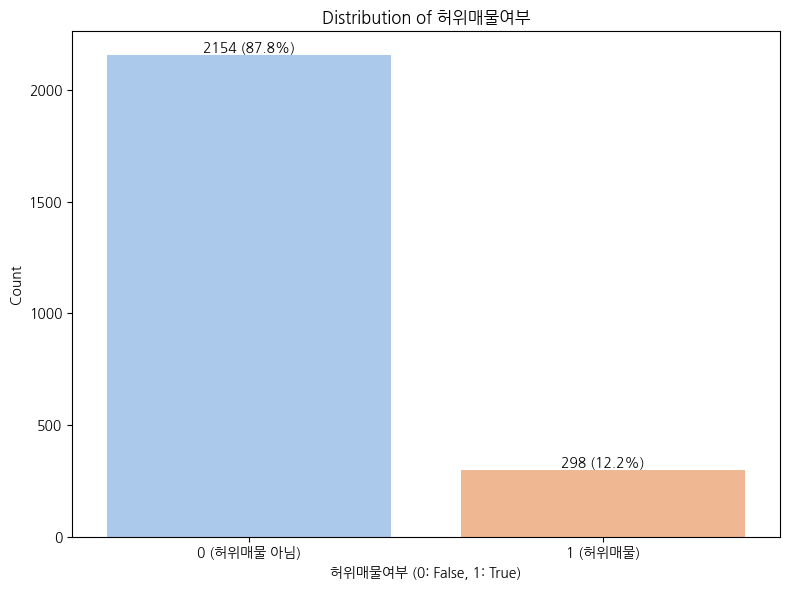

In [46]:
# 허위매물여부 비율 계산
counts = train['허위매물여부'].value_counts()
percentages = counts / counts.sum() * 100  # 비율 계산

# 바차트 생성
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x=counts.index, y=counts.values, palette='pastel')
plt.title('Distribution of 허위매물여부')
plt.xlabel('허위매물여부 (0: False, 1: True)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0 (허위매물 아님)', '1 (허위매물)'])

# 개수와 비율을 바차트 위에 추가
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())} ({p.get_height() / counts.sum() * 100:.1f}%)',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


# 결측치 확인

In [47]:
train.isnull().sum()

,0
매물확인방식,0
보증금,0
월세,0
전용면적,787
해당층,229
총층,16
방향,0
방수,16
욕실수,18
주차가능여부,0


In [48]:
test.isnull().sum()

,0
매물확인방식,0
보증금,0
월세,0
전용면적,184
해당층,50
총층,2
방향,0
방수,2
욕실수,2
주차가능여부,0


In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   매물확인방식  2452 non-null   object 
 1   보증금     2452 non-null   float64
 2   월세      2452 non-null   int64  
 3   전용면적    1665 non-null   float64
 4   해당층     2223 non-null   float64
 5   총층      2436 non-null   float64
 6   방향      2452 non-null   object 
 7   방수      2436 non-null   float64
 8   욕실수     2434 non-null   float64
 9   주차가능여부  2452 non-null   object 
 10  총주차대수   1756 non-null   float64
 11  관리비     2452 non-null   int64  
 12  중개사무소   2452 non-null   object 
 13  제공플랫폼   2452 non-null   object 
 14  게재일     2452 non-null   object 
 15  허위매물여부  2452 non-null   int64  
dtypes: float64(7), int64(3), object(6)
memory usage: 306.6+ KB


In [50]:
train.describe()

,보증금,월세,전용면적,해당층,총층,방수,욕실수,총주차대수,관리비,허위매물여부
count,2.452000e+03,2452.000000,1665.000000,2223.000000,2436.000000,2436.000000,2434.000000,1756.000000,2452.000000,2452.000000
mean,1.574188e+08,380420.065253,27.009628,4.848403,8.052545,1.378079,1.034511,20.332574,5.477977,0.121533
std,1.212794e+08,206425.413601,7.951757,3.543348,4.920112,0.485007,0.182575,28.939900,5.631185,0.326813
min,5.000000e+06,0.000000,17.500000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,7.500000e+07,200000.000000,19.800000,2.000000,4.000000,1.000000,1.000000,4.000000,0.000000,0.000000
50%,1.325000e+08,380000.000000,26.400000,4.000000,6.000000,1.000000,1.000000,10.000000,5.000000,0.000000
75%,1.890000e+08,550000.000000,32.110000,6.000000,10.000000,2.000000,1.000000,31.000000,9.000000,0.000000
max,4.090000e+08,750000.000000,49.970000,21.000000,21.000000,2.000000,2.000000,590.000000,96.000000,1.000000


# 결측치 있는 열 제거

In [51]:
# train 데이터프레임의 결측치가 있는 열 제거
train = train.dropna(axis=1)

# test 데이터프레임의 결측치가 있는 열 제거
test = test.dropna(axis=1)

In [52]:
train.isnull().sum()

,0
매물확인방식,0
보증금,0
월세,0
방향,0
주차가능여부,0
관리비,0
중개사무소,0
제공플랫폼,0
게재일,0
허위매물여부,0


In [53]:
test.isnull().sum()

,0
매물확인방식,0
보증금,0
월세,0
방향,0
주차가능여부,0
관리비,0
중개사무소,0
제공플랫폼,0
게재일,0


# 데이터 변환

# 날짜 변경

* yyyy-mm-dd 형태를 분리하여 컬럼으로 분리
* 게제일 컬럼 DROP

In [54]:
# 날짜 컬럼을 datetime 형식으로 변환
train['게재일'] = pd.to_datetime(train['게재일'])
test['게재일'] = pd.to_datetime(test['게재일'])

# 연도, 월, 일, 요일 추출
for df in [train, test]:
    df['연도'] = df['게재일'].dt.year % 100  # 연도를 2자리로 변환
    df['월'] = df['게재일'].dt.month
    df['일'] = df['게재일'].dt.day

# '게재일' 컬럼 삭제
train.drop(columns=['게재일'], inplace=True)
test.drop(columns=['게재일'], inplace=True)

<ipython-input-54-d8e8d8694abe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['게재일'] = pd.to_datetime(train['게재일'])
<ipython-input-54-d8e8d8694abe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['게재일'] = pd.to_datetime(test['게재일'])
<ipython-input-54-d8e8d8694abe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

# 그래프 확인

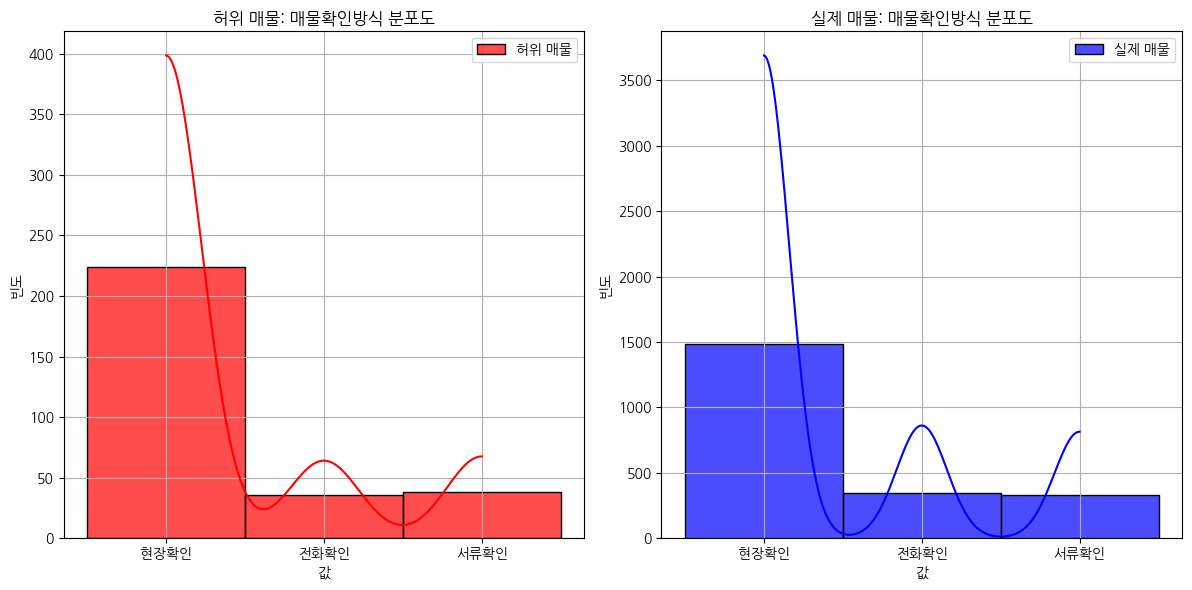

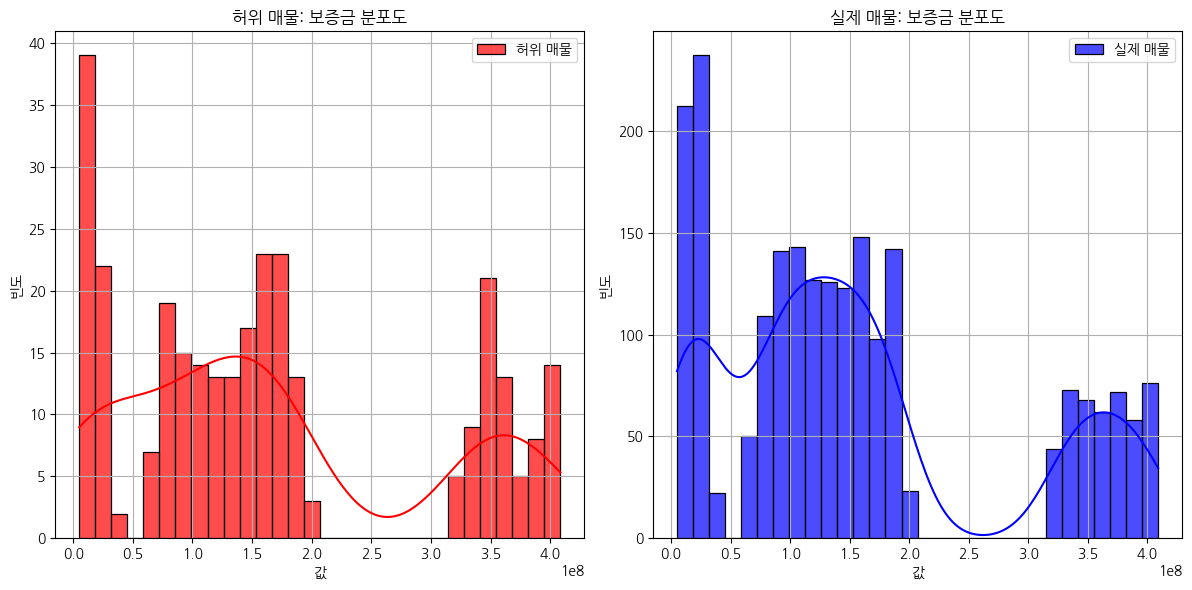

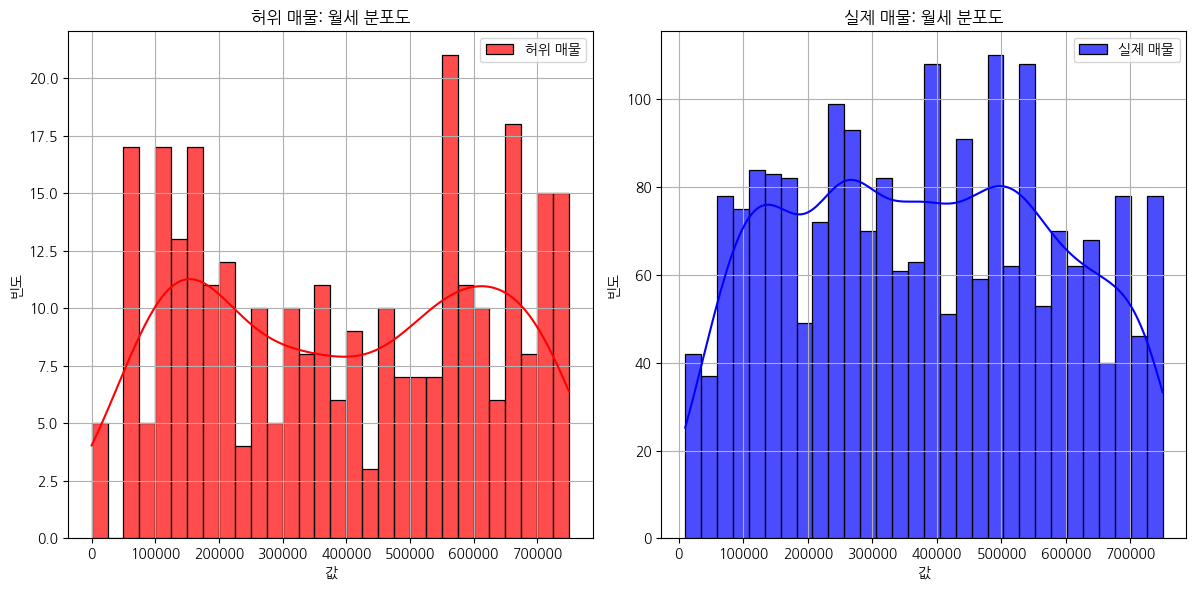

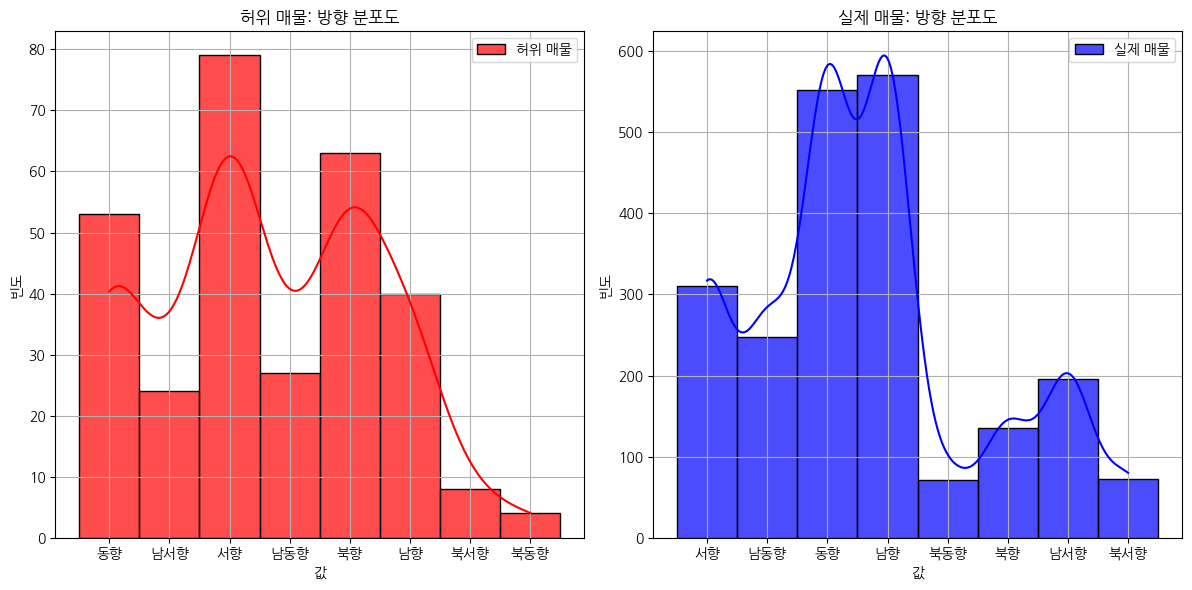

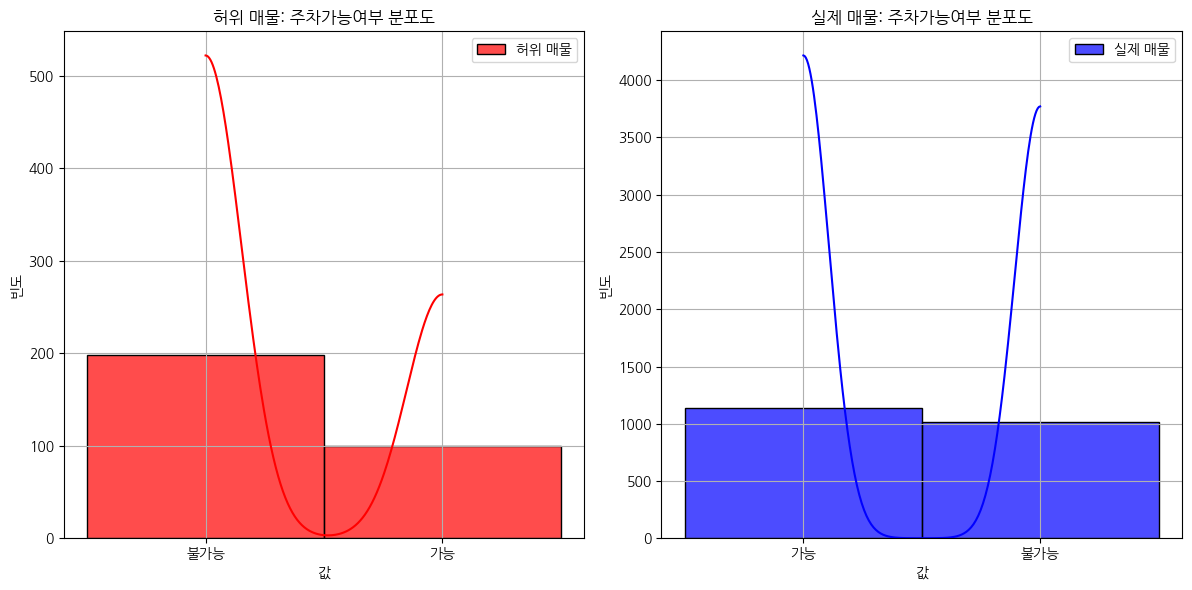

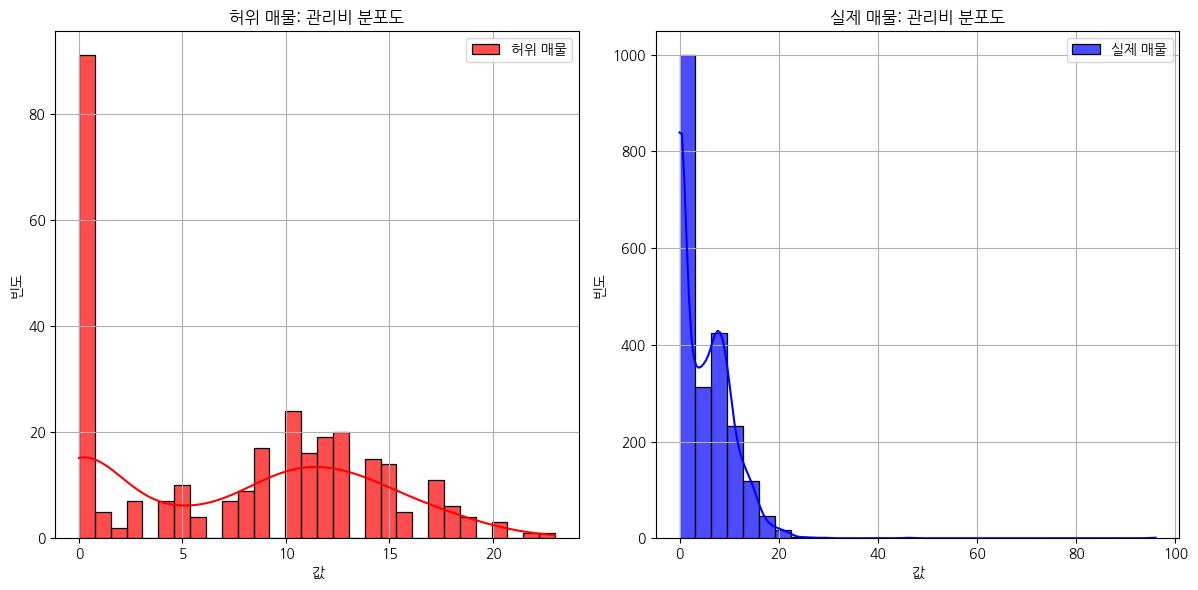

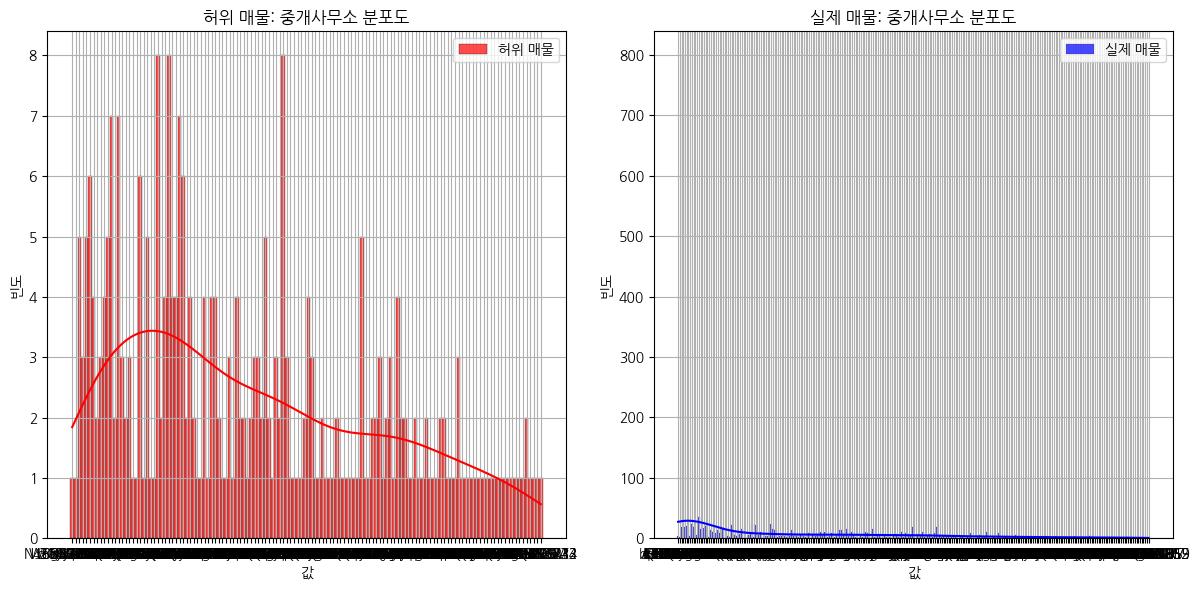

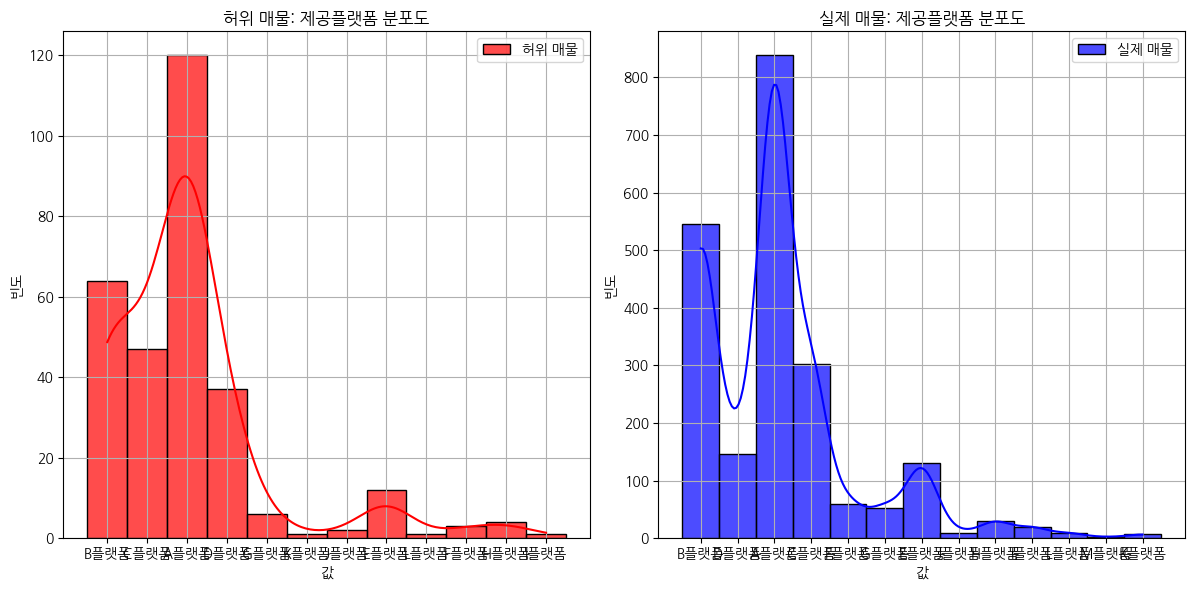

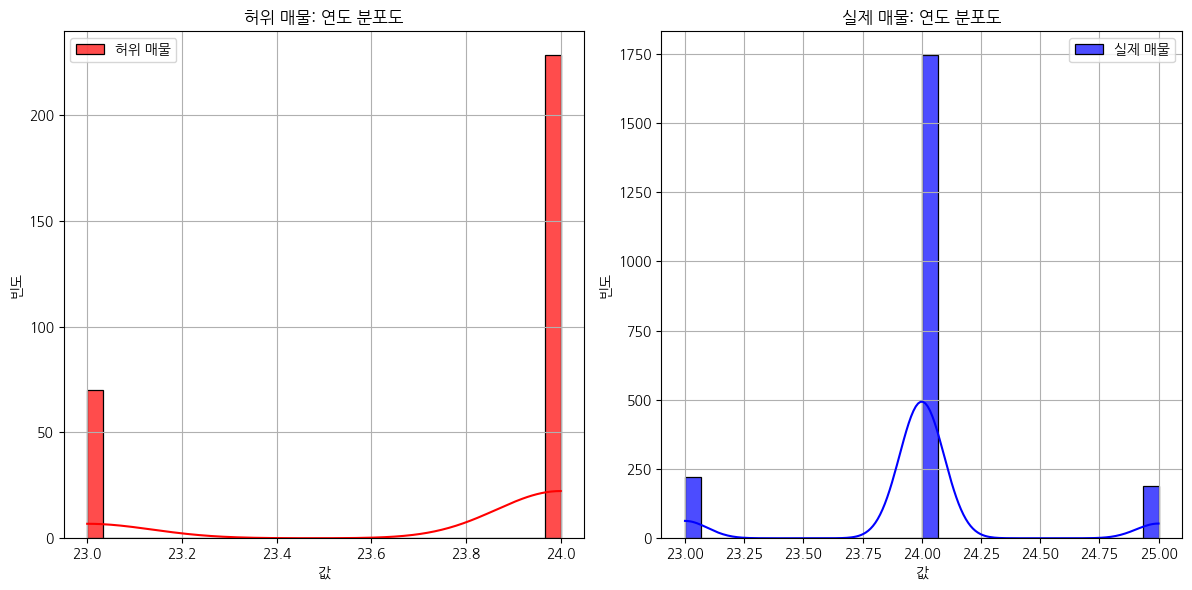

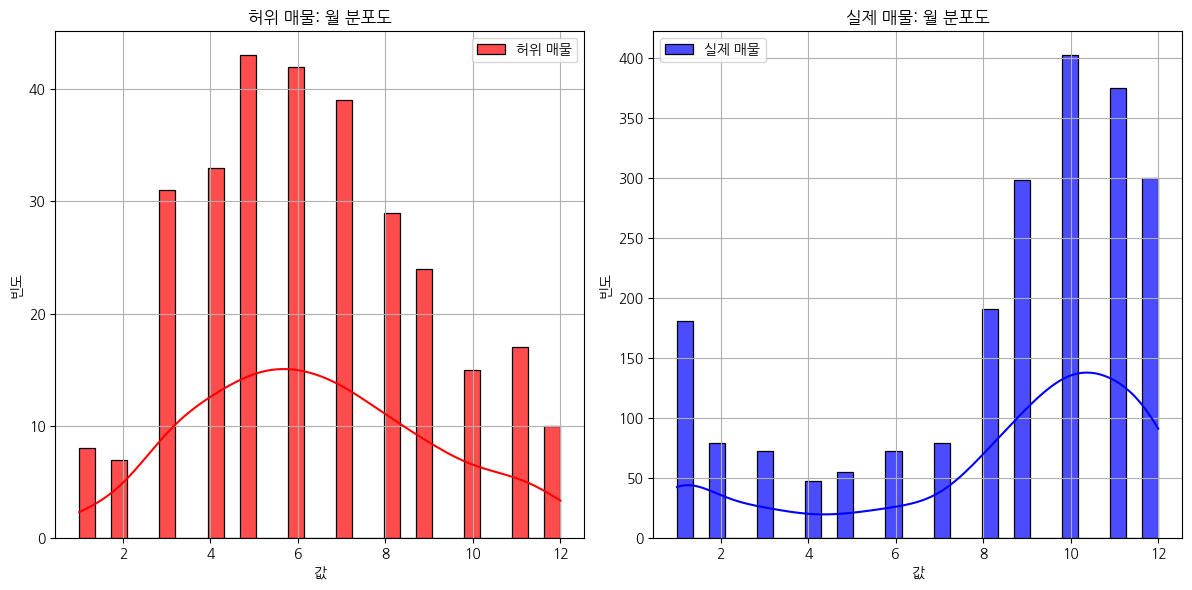

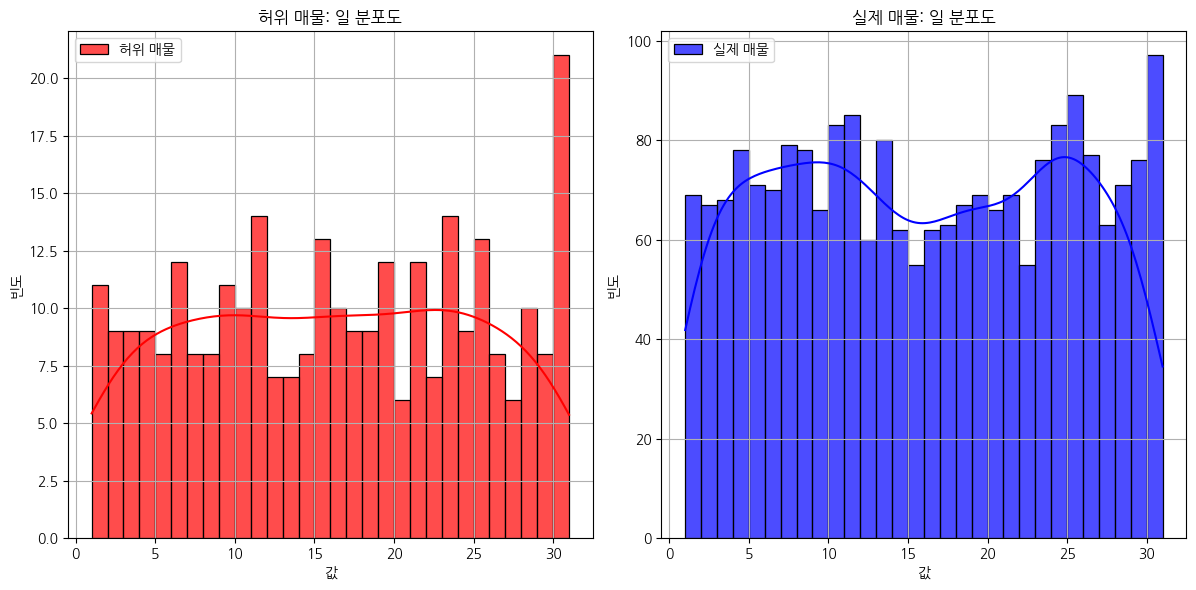

In [55]:
# 허위 매물 여부에 따라 train 데이터 분리
train_fake = train[train['허위매물여부'] == 1]  # 허위 매물인 경우
train_real = train[train['허위매물여부'] == 0]  # 허위 매물이 아닌 경우

# 각 컬럼에 대해 train 및 test 데이터의 분포도 그리기
for column in train.columns:
    if column != '허위매물여부':  # 허위 매물 여부 컬럼은 제외
        plt.figure(figsize=(18, 6))  # 각 플롯의 크기 설정

        # 허위 매물 분포
        plt.subplot(1, 3, 1)  # 1행 3열의 첫 번째 플롯
        sns.histplot(train_fake[column], kde=True, color='red', label='허위 매물', alpha=0.7, bins=30)
        plt.title(f'허위 매물: {column} 분포도')  # 제목 설정
        plt.xlabel('값')  # x축 레이블
        plt.ylabel('빈도')  # y축 레이블
        plt.grid()
        plt.legend()  # 범례 추가

        # 실제 매물 분포
        plt.subplot(1, 3, 2)  # 1행 3열의 두 번째 플롯
        sns.histplot(train_real[column], kde=True, color='blue', label='실제 매물', alpha=0.7, bins=30)
        plt.title(f'실제 매물: {column} 분포도')  # 제목 설정
        plt.xlabel('값')  # x축 레이블
        plt.ylabel('빈도')  # y축 레이블
        plt.grid()
        plt.legend()  # 범례 추가

        plt.tight_layout()  # 서브플롯 간 간격 조정
        plt.show()  # 플롯 출력

# 데이터 분포 확인 (컬럼 '월')

1. 허위매물여부 0과 1에 따른 '월' 분포 확인
2. 확인 결과, 혀위매물여부 1은 정규분포의 모양읠 띔
3. 허위매물여부 0의 정규화 시도
4. 부분 정규화 시도 (8~12월) 일부 제거

<ipython-input-56-5de7eff5338a>:18: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


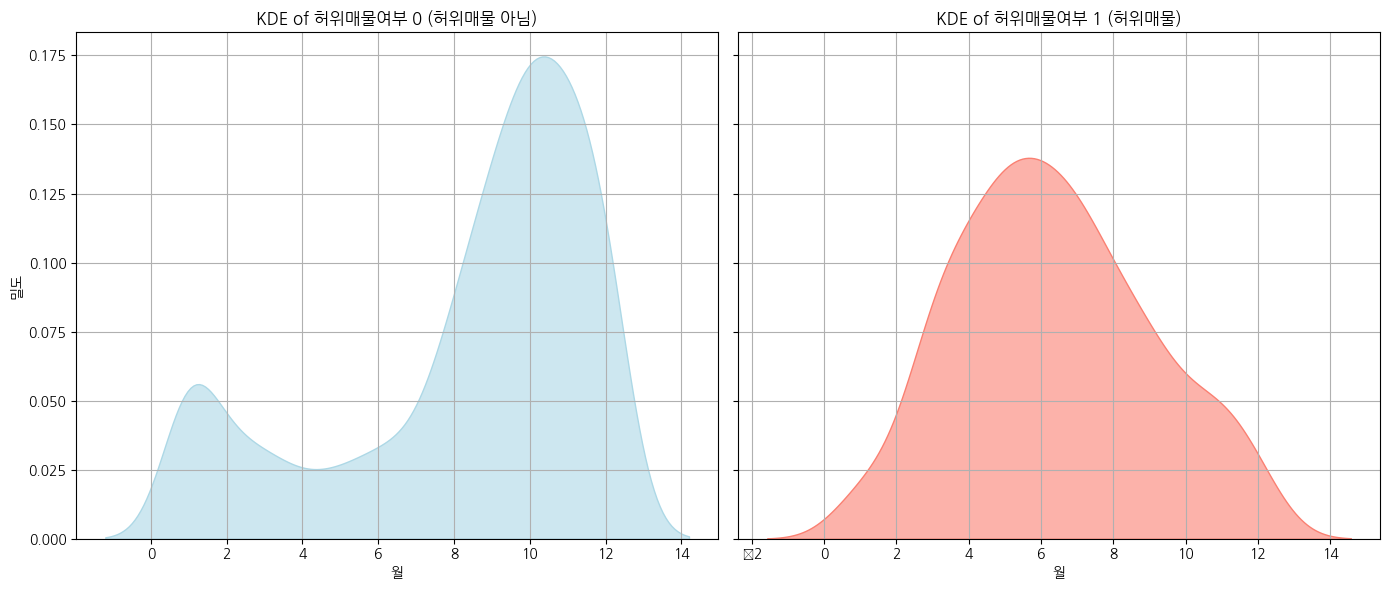

In [56]:
# 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# 허위매물여부 0의 밀도
sns.kdeplot(data=train[train['허위매물여부'] == 0], x='월', ax=axes[0], fill=True, color='lightblue', alpha=0.6)
axes[0].set_title('KDE of 허위매물여부 0 (허위매물 아님)')
axes[0].set_xlabel('월')
axes[0].set_ylabel('밀도')
axes[0].grid(True)  # 그리드 추가

# 허위매물여부 1의 밀도
sns.kdeplot(data=train[train['허위매물여부'] == 1], x='월', ax=axes[1], fill=True, color='salmon', alpha=0.6)
axes[1].set_title('KDE of 허위매물여부 1 (허위매물)')
axes[1].set_xlabel('월')
axes[1].set_ylabel('밀도')
axes[1].grid(True)  # 그리드 추가

plt.tight_layout()
plt.show()

In [57]:
# 허위매물여부 0과 1로 나누기
fake_data = train[train['허위매물여부'] == 0]  # 허위매물여부가 0인 데이터
real_data = train[train['허위매물여부'] == 1]  # 허위매물여부가 1인 데이터

print(fake_data['월'].value_counts())

월
10    402
11    375
12    300
9     298
8     191
1     181
7      79
2      79
6      73
3      73
5      55
4      48
Name: count, dtype: int64


In [58]:
remeve_num = 100

# 허위매물여부가 0인 데이터에서 랜덤으로 행 제거
desired_counts = {
    8: remeve_num,   # 월 8에 대해 제거할 개수
    9: remeve_num,   # 월 9에 대해 제거할 개수
    10: remeve_num,  # 월 10에 대해 제거할 개수
    11: remeve_num,  # 월 11에 대해 제거할 개수
    12: remeve_num   # 월 12에 대해 제거할 개수
}

# 각 월에 대해 랜덤으로 제거할 행 선택
for month, count in desired_counts.items():
    # 해당 월의 행 추출
    month_data = fake_data[fake_data['월'] == month]

    # 랜덤으로 제거할 행 선택
    if len(month_data) >= count:
        rows_to_remove = month_data.sample(n=count, random_state=42)  # 랜덤으로 제거할 행 샘플링
    else:
        rows_to_remove = month_data  # 원하는 개수보다 적으면 모두 선택

    # fake_data에서 해당 행 제거
    fake_data = fake_data.drop(rows_to_remove.index)

# 허위매물여부가 0인 데이터와 1인 데이터 합치기
train = pd.concat([fake_data, real_data], ignore_index=True)

# 결과 출력
print("Updated train DataFrame after removing specified rows:")
print(train['허위매물여부'].value_counts())


Updated train DataFrame after removing specified rows:
허위매물여부
0    1654
1     298
Name: count, dtype: int64


In [59]:
print(fake_data['제공플랫폼'].value_counts())
print(real_data['제공플랫폼'].value_counts())
print(test['제공플랫폼'].value_counts())

제공플랫폼
A플랫폼    654
B플랫폼    404
C플랫폼    232
D플랫폼    118
E플랫폼    106
F플랫폼     41
G플랫폼     40
H플랫폼     21
I플랫폼     15
J플랫폼      9
L플랫폼      8
K플랫폼      5
M플랫폼      1
Name: count, dtype: int64
제공플랫폼
A플랫폼    120
B플랫폼     64
C플랫폼     47
D플랫폼     37
E플랫폼     12
G플랫폼      6
H플랫폼      4
F플랫폼      3
J플랫폼      2
K플랫폼      1
L플랫폼      1
I플랫폼      1
Name: count, dtype: int64
제공플랫폼
A플랫폼    244
B플랫폼    164
C플랫폼     78
D플랫폼     45
E플랫폼     37
F플랫폼     21
G플랫폼     10
I플랫폼      5
L플랫폼      3
H플랫폼      3
K플랫폼      2
N플랫폼      1
Name: count, dtype: int64


# 컬럼 요소 인코딩

In [60]:

# LabelEncoder 인스턴스 생성
label_encoders = {}
label_encode_cols = train.select_dtypes(include=['object']).columns.difference(['ID']).tolist()

# train 데이터프레임의 각 object 타입 컬럼에 대해 LabelEncoder 적용 (ID 제외)
for col in label_encode_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    label_encoders[col] = le  # LabelEncoder 저장

# test 데이터프레임의 각 object 타입 컬럼에 대해 LabelEncoder 적용 (ID 제외)
for col in label_encode_cols:
    if col in test.columns:
        le = label_encoders[col]
        test[col] = test[col].astype(str)  # 데이터 타입을 문자열로 변환
        unseen = set(test[col].unique()) - set(le.classes_)  # 보지 못한 값 확인

        # 보지 못한 클래스 추가
        if unseen:
            le.classes_ = np.append(le.classes_, list(unseen))  # 새로운 클래스 추가

        # 변환
        test[col] = le.transform(test[col])

In [61]:
train

,매물확인방식,보증금,월세,방향,주차가능여부,관리비,중개사무소,제공플랫폼,허위매물여부,연도,월,일
0,2,170500000.0,200000,0,1,0,211,3,0,24,12,26
1,2,163500000.0,30000,0,0,10,27,0,0,24,11,26
2,1,153000000.0,530000,2,0,0,79,0,0,24,9,12
3,2,139500000.0,590000,3,1,0,149,1,0,25,3,3
4,2,120500000.0,440000,6,0,3,27,1,0,24,5,23
...,...,...,...,...,...,...,...,...,...,...,...,...
1947,2,81500000.0,310000,6,1,13,177,3,1,23,8,16
1948,2,341000000.0,550000,1,1,15,89,0,1,24,6,18
1949,2,26500000.0,570000,4,1,0,15,3,1,24,5,6
1950,1,343000000.0,470000,2,1,14,135,0,1,24,7,4


In [62]:
test

,매물확인방식,보증금,월세,방향,주차가능여부,관리비,중개사무소,제공플랫폼,연도,월,일
0,0,223000000.0,530000,2,1,7,134,3,24,10,21
1,0,150500000.0,590000,7,1,11,27,3,23,9,2
2,2,47000000.0,200000,1,1,0,65,1,24,4,3
3,0,133000000.0,250000,2,0,5,11,1,24,9,19
4,2,108000000.0,380000,2,1,0,131,0,24,11,10
...,...,...,...,...,...,...,...,...,...,...,...
608,2,152500000.0,340000,0,0,2,176,0,24,9,24
609,1,226500000.0,750000,1,0,7,215,1,24,9,4
610,2,169500000.0,500000,2,1,6,27,5,24,4,20
611,2,180000000.0,340000,0,0,8,45,2,24,11,17


# 보증금과 월세 값의 데이터 변형

In [63]:
# 보증금과 월세 컬럼 나누기
train['보증금'] = train['보증금'] / 100000
train['월세'] = train['월세'] / 10000

test['보증금'] = test['보증금'] / 100000
test['월세'] = test['월세'] / 10000

# Data Feature Drop

In [64]:
x_train = train.drop(['허위매물여부', '주차가능여부', '매물확인방식', '방향'], axis=1) #'주차가능여부', '매물확인방식'
y_train = train['허위매물여부']

x_test = test.drop(['주차가능여부', '매물확인방식', '방향'], axis=1)

# Scaler -> StandardScaler

In [65]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 인스턴스 생성
scaler = StandardScaler()

# StandardScaler를 사용하여 x_train과 x_test 정규화
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)



In [66]:
x_test_scaled

array([[ 0.54187817,  0.7241596 ,  0.2808135 , ...,  0.03695803,
         0.66797789,  0.58921484],
       [-0.05266763,  1.01450766,  1.03454047, ..., -2.14916526,
         0.38799231, -1.57271631],
       [-0.90143302, -0.87275474, -1.03820871, ...,  0.03695803,
        -1.01193558, -1.45893046],
       ...,
       [ 0.10314437,  0.57898557,  0.09238175, ...,  0.03695803,
        -1.01193558,  0.47542899],
       [ 0.189251  , -0.19527593,  0.46924524, ...,  0.03695803,
         0.94796347,  0.13407144],
       [-0.11417237, -0.09849324,  0.09238175, ...,  0.03695803,
        -0.73195   , -1.34514461]])

# 모델 학습 (LGBM)

In [67]:


# LightGBM Classifier 초기화
model_lgb = LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    learning_rate=0.1,
    num_leaves=31,
    n_estimators=300,
    random_state=42
)

# 모델 훈련
model_lgb.fit(x_train_scaled, y_train)

# 예측
predictions_lgb = model_lgb.predict(x_test_scaled)

[LightGBM] [Info] Number of positive: 298, number of negative: 1654
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 1952, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.152664 -> initscore=-1.713858
[LightGBM] [Info] Start training from score -1.713858


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Feature Importance

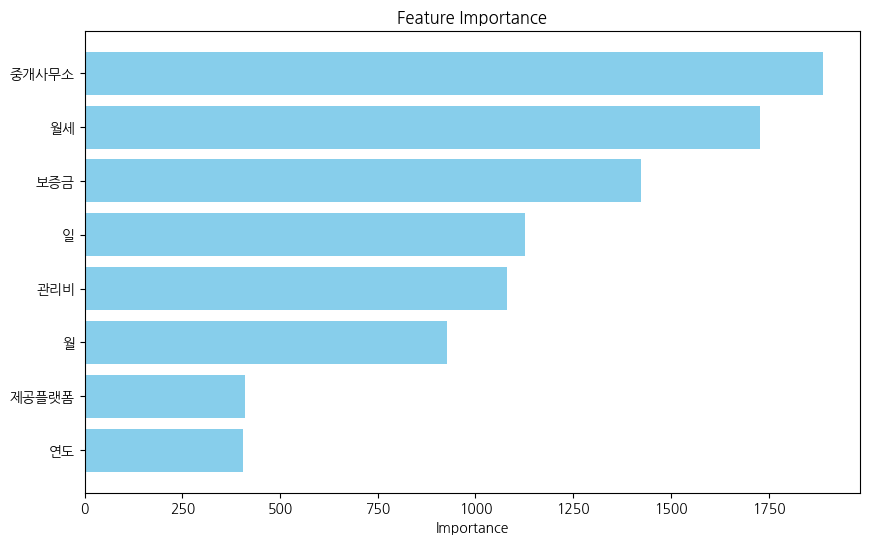

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importance 추출
feature_importances = model_lgb.feature_importances_

# 특성 이름 가져오기
feature_names = x_train.columns

# 중요도와 특성 이름을 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 중요도에 따라 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 내림차순으로 표시
plt.show()


In [69]:
# 결과를 Pandas Series로 변환
pred_lgb = pd.Series(predictions_lgb)
pred_lgb

,0
0,0
1,0
2,1
3,0
4,0
...,...
608,0
609,0
610,0
611,0


In [70]:
submit = pd.read_csv('./sample_submission.csv')
submit['허위매물여부'] = pred_lgb
submit.head()

,ID,허위매물여부
0,TEST_000,0
1,TEST_001,0
2,TEST_002,1
3,TEST_003,0
4,TEST_004,0


In [71]:
counts = submit['허위매물여부'].value_counts()
counts

,count
허위매물여부,
0,549
1,64


In [72]:
submit.to_csv('./test_177.csv',index=False)